# Loan Default Prediction: A Neural Network Approach
22 July 2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Matplotlib
plt.rcParams['figure.figsize'] = 16,6
plt.rcParams.update({'font.size': 16})

# Seaborn
sns.set_style('whitegrid')
sns.set_palette("PuBuGn_d")

# Keras
from tensorflow import keras

# Sci-Kit
from sklearn.preprocessing import StandardScaler

### Data
The data that we will be using comes from the Lending Club Company -- a peer-to-peer lending company. The data contains various features describing the loans issued through the said company.

In [2]:
# Set Data Directory
data_dir = '../Data_Hands-on/'

# Read Files
X_train = pd.read_csv(data_dir + 'X_train.csv')
X_test  = pd.read_csv(data_dir + 'X_test.csv' )
y_train = pd.read_csv(data_dir + 'y_train.csv')
y_test  = pd.read_csv(data_dir + 'y_test.csv')

#### Pre-processing
Fill all NaNs with zeros

In [3]:
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

Standardization: It is always a good practice to standardize the numerical features so that any numerical computations during training will be executed in a fast manner since we will be able to avoid operations involving significantly large values.

Note that the proper way to standardize the test set is to use the parameters ($\mu$ and $\sigma$) from the training set. This is to ensure that any predictions on unseen data will still be scored relative to how the model was trained.

In [4]:
# Initialize scaler class
stnd_scl = StandardScaler()

# Fit and transform training set
X_train_stnd = stnd_scl.fit_transform(X_train)

# Transform test set
X_test_stnd = stnd_scl.transform(X_test)

## Building the Model
For simplicity, we would just create a "Vanilla" Neural Network.

Here is the outline of the model architecture that we intend to build:
- 1 input layer 
- 1 densely connected (hidden) layer
- 1 dropout layer to minimize the effect of overfitting
- 1 output layer (densely connected layer with 1 output node)

<i>Rule of Thumb: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw#:~:text=The%20number%20of%20hidden%20neurons,size%20of%20the%20input%20layer. </i>

<center> <img src="../images/nn.svg" width="4000" height="4000"/> </center>

<center> <i>The network architecture for this sample notebook </i></center>

In [5]:
# Use sequential model since the order of the layers is important
model = keras.Sequential()

# Add the input layer
model.add(keras.layers.Dense(
            units  = 11,                   # Number of features that will be passed on to the next layer
            input_dim = X_train.shape[1],  # Input demnsions = number of features in training set
            activation = 'relu'            # Use ReLU to avoid the problem of vanishing gradient
            )
         )

# Add dropout layer to minimize overfitting
model.add(keras.layers.Dropout(
             rate=0.5 
            )
         )

# Add output layer
model.add(keras.layers.Dense(
            units = 1,                     # One output node to signify the probability of good/bad loan
            activation = 'sigmoid'         # 'Sigmoid' is used to ensure that the output is between 0 and 1
            )
         )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Sanity Check

In [6]:
model.compute_output_shape(input_shape = (50000,28))

TensorShape([Dimension(50000), Dimension(1)])

### Compiling the Model

Since we will be dealing with binary classifications (probability values within 0 and 1), our loss function should be <b>Binary Crossentropy</b>. For now we will use the <b>Adam</b> optimizer since it is the most flexible optimzer available in Keras (best optimizer to deal with non convex problems).

$$
L_{\text{Cross_Entropy}} = -\left[y \ln(p) + (1-y) \ln(1-p)\right]
$$

where $y$ can only be $0$ or $1$, and $p$ is predicted probability

In [7]:
model.compile(loss = 'binary_crossentropy',
             optimizer ='adam',
             metrics = ['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Fitting the Model

Note on Epoch and Batch
- <b> Epoch </b> - One pass through all the rows in the training dataset
- <b> Batch </b> - One or more samples considered by the model within an epoch before weights are updated

<i> machinelearningmastery.com/tutorial-first-neural-network-python-keras/ </i>

As all Neural Network Models, the training process will run for a number of iterations through the entire dataset (this is called the epoch). We do not update the weights of the model for each data/row, but are updated based on the loss of an entire batch (average). Note that the lower the batch size and the higher the epoch values, the longer the computation.

#### Validation

It is important to determine the performance of our model to unseen data. We then need to split our training set further to accommodate the validation set. Let us choose 45,000  random rows to be the ones to update the weights, while the remaining 5,000  will be used to compute the validation accuracy of the training.

In [8]:
np.random.seed(69) # Reproducibility

# Shuffle the response variable together with the features
val = np.hstack([X_train_stnd, y_train])
np.random.shuffle(val)

# Split Training Set
X_train_stnd_not_val = val[:45000, :-1]
X_train_stnd_val     = val[45000:, :-1]
y_train_not_val      = val[:45000, -1]
y_train_val           = val[45000:, -1]

Get the training history to see if there is overfitting/underfitting

In [9]:
history = model.fit(X_train_stnd_not_val, y_train_not_val, epochs = 10,
                   validation_data=(X_train_stnd_val,y_train_val), batch_size = 16
                   )

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 20s 437us/sample - loss: 0.3254 - acc: 0.8485 - val_loss: 0.0834 - val_acc: 0.9798
Epoch 2/10
45000/45000 [==============================] - 20s 446us/sample - loss: 0.1096 - acc: 0.9673 - val_loss: 0.0494 - val_acc: 0.9862
Epoch 3/10
45000/45000 [==============================] - 20s 446us/sample - loss: 0.0882 - acc: 0.9742 - val_loss: 0.0439 - val_acc: 0.9880
Epoch 4/10
45000/45000 [==============================] - 20s 436us/sample - loss: 0.0766 - acc: 0.9756 - val_loss: 0.0388 - val_acc: 0.9880
Epoch 5/10
45000/45000 [==============================] - 20s 440us/sample - loss: 0.0727 - acc: 0.9775 - val_loss: 0.0354 - val_acc: 0.9886
Epoch 6/10
45000/45000 [==============================] - 20s 436us/sample - loss: 0.0673 - acc: 0.9784 - val_loss: 0.0331 - val_acc: 0.9898
Epoch 7/10
45000/45000 [==============================] - 21s 458us/sample - loss: 0.0643 - acc: 0.9792 -

Plot training history

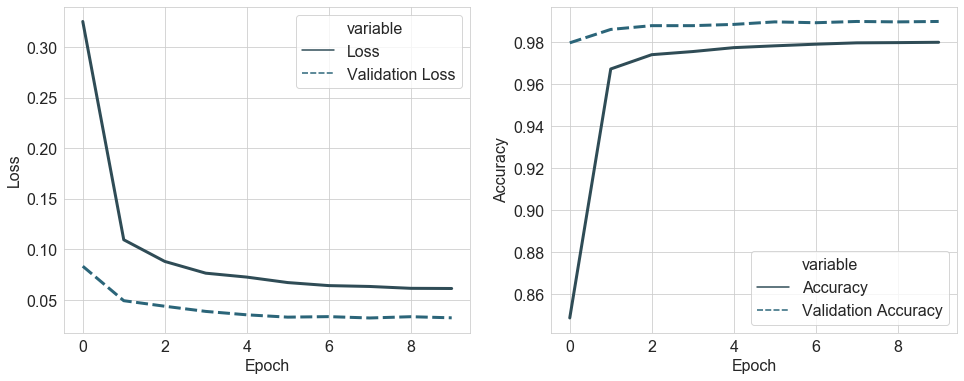

In [10]:
def learning_curve(hist, v1 = False):
    """Creates two plots. One is the loss vs epoch graph, and the other one
    is the accuracy vs epoch graph
    """
    if v1:
        acc = 'acc'
        val_acc = 'val_acc'
    else:
        acc = 'accuracy'
        val_acc = 'val_accuracy'
    # Obtain range of x values
    x = range(len(hist['loss']))
    
    # Create dataframes
    for_plot_df_loss = pd.DataFrame({'Epoch':x,
                               'Loss':hist['loss'],
                                'Validation Loss':hist['val_loss']})
    
    for_plot_df_acc = pd.DataFrame({'Epoch':x,
                                    'Accuracy':hist[acc],
                                    'Validation Accuracy':hist[val_acc]})
    
    # Initialize figure
    fig, ax = plt.subplots(1,2)
    
    # Plot loss
    sns.lineplot(x='Epoch',
                y='value',
                hue='variable',
                style='variable',
                data=pd.melt(for_plot_df_loss, ['Epoch']),
                ax=ax[0],
                lw=3)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    
    # Plot Accuracy
    sns.lineplot(x='Epoch',
                y='value',
                hue='variable',
                style='variable',
                data=pd.melt(for_plot_df_acc, ['Epoch']),
                ax = ax[1],
                lw= 3)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    
    plt.legend(loc='best')
    plt.show()
    
    
learning_curve(history.history,v1=True)

Since the Validation Curves (both in Loss and Accuracy) do not divert far from the training curve, we can be confident that there is no overfitting. The value of the accuracy also shows that we are not underfitting in the training and validation phase.

### On Unseen Data - Test Set

In [11]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

1000/1000 - 0s - loss: 3259.1051 - acc: 0.8980


With our Vanilla Neural Network, we have attained 89.80% accuracy on the test set.